In [11]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import random


In [ ]:

class Neuron:
    """Base neuron class with integrate-and-fire dynamics"""
    def __init__(self, name: str, threshold: float = -50.0, reset: float = -70.0, 
                 rest: float = -70.0, tau: float = 10.0):
        self.name = name
        self.threshold = threshold
        self.reset = reset
        self.rest = rest
        self.tau = tau
        self.membrane_potential = rest
        self.spike_times = []
        self.current_input = 0.0
        self.last_spike_time = -np.inf
        self.incoming_synapses = {} 
        
    def update(self, dt: float, input_current: float = 0.0):
        """Update neuron state using Euler integration"""
        self.current_input = input_current
        
        # Integrate-and-fire dynamics
        dv = (-(self.membrane_potential - self.rest) + input_current) / self.tau
        self.membrane_potential += dv * dt
        
        # Check for spike
        if self.membrane_potential >= self.threshold:
            self.spike_times.append(self.last_spike_time)
            self.last_spike_time = 0.0  # Reset spike timer
            self.membrane_potential = self.reset
            return True
        return False
    
    def reset_neuron(self):
        """Reset neuron to resting state"""
        self.membrane_potential = self.rest
        self.spike_times = []
        self.last_spike_time = -np.inf

class DopamineNeuron(Neuron):
    """VTA Dopamine neuron with baseline and burst modes"""
    def __init__(self, name: str):
        super().__init__(name, threshold=-45.0, rest=-65.0)
        self.baseline_rate = 0.02  # Baseline firing rate
        self.burst_mode = False
        self.dopamine_release = 0.05
        
    def set_burst_mode(self, burst: bool):
        """Set burst firing mode for reward signaling"""
        self.burst_mode = burst
        
    def update(self, dt: float, input_current: float = 0.0):
        """Update with dopamine-specific dynamics"""
        if self.burst_mode:
            # Higher firing rate during burst
            firing_rate = 0.8
        else:
            # Baseline firing rate
            firing_rate = self.baseline_rate
            
        # Add stochastic firing
        if random.random() < firing_rate * dt:
            self.dopamine_release = 1.0 if self.burst_mode else 0.3
            return super().update(dt, input_current + 15.0)
        
        # Set dopamine release based on baseline rate (lower rate = lower dopamine)
        self.dopamine_release = max(0.05, self.baseline_rate * 3.0)  # Scale baseline to dopamine
        return super().update(dt, input_current)

class MSNeuron(Neuron):
    """Medium Spiny Neuron (D1 or D2 type)"""
    def __init__(self, name: str, receptor_type: str):
        super().__init__(name, threshold=-45.0, rest=-70.0)
        self.receptor_type = receptor_type  # 'D1' or 'D2'
        self.dopamine_sensitivity = 1.0
        
    def dopamine_response(self, dopamine_level: float):
        """Calculate response to dopamine based on receptor type"""
        if self.receptor_type == 'D1':
            # D1 receptors: activated by high dopamine (burst)
            if dopamine_level > 0.6:  # Higher threshold for burst detection
                return 25.0  # Strong excitatory response
            else:
                return 5.0   # Baseline excitation

                # return -2.0  # Slightly inhibited at baseline
        else:  # D2
            # D2 receptors: inhibited by baseline dopamine
            if dopamine_level > 0.15:  # Lower threshold for baseline detection
                # return -20.0  # Strong inhibitory response
                return -15.0  # moderate inhibitory response
            else:
                return 20.0  # Strongly disinhibited when dopamine drops

class GABANeuron(Neuron):
    """GABA inhibitory neuron"""
    def __init__(self, name: str, location: str):
        super().__init__(name, threshold=-45.0, rest=-65.0)
        self.location = location  # 'VTA' or 'VP'

class Synapse:
    """Synapse with STDP"""
    def __init__(self, pre_neuron: Neuron, post_neuron: Neuron, 
                 weight: float = 0.5, delay: float = 1.0):
        self.pre_neuron = pre_neuron
        self.post_neuron = post_neuron
        self.weight = weight
        self.delay = delay
        self.spike_buffer = []  # Buffer for delayed spikes
        
        # STDP parameters
        self.A_plus = 0.01  # LTP amplitude
        self.A_minus = -0.01  # LTD amplitude
        self.tau_plus = 20.0  # LTP time constant
        self.tau_minus = 20.0  # LTD time constant
        
    def update_stdp(self, dt: float):
        """Update synaptic weight using STDP"""
        if len(self.pre_neuron.spike_times) == 0 or len(self.post_neuron.spike_times) == 0:
            return
            
        # Get recent spikes
        pre_spikes = self.pre_neuron.spike_times[-5:]  # Last 5 spikes
        post_spikes = self.post_neuron.spike_times[-5:]  # Last 5 spikes
        
        weight_change = 0.0
        
        for pre_time in pre_spikes:
            for post_time in post_spikes:
                dt_spike = post_time - pre_time
                
                if dt_spike > 0:  # Post before pre (LTP)
                    weight_change += self.A_plus * np.exp(-dt_spike / self.tau_plus)
                elif dt_spike < 0:  # Pre before post (LTD)
                    weight_change += self.A_minus * np.exp(dt_spike / self.tau_minus)
        
        self.weight += weight_change
        self.weight = np.clip(self.weight, 0.0, 2.0)  # Bound weights
        
    def transmit(self, spike: bool, current_time: float):
        """Transmit spike through synapse with delay"""
        if spike:
            self.spike_buffer.append(current_time + self.delay)
        
        # Check for delayed spikes
        transmitted_spikes = []
        for spike_time in self.spike_buffer:
            if current_time >= spike_time:
                transmitted_spikes.append(spike_time)
        
        # Remove transmitted spikes from buffer
        for spike_time in transmitted_spikes:
            self.spike_buffer.remove(spike_time)
        
        return len(transmitted_spikes) * self.weight

class StriatumNetwork:
    """Complete striatum network model"""
    def __init__(self, n_d1_msn=1000, n_d2_msn=1000, n_vta_da=1000, 
                 n_vta_gaba=300, n_vp_gaba=300):
        self.time = 0.0
        self.dt = 0.1
        
        # Store neuron counts
        self.neuron_counts = {
            'D1_MSN': n_d1_msn,
            'D2_MSN': n_d2_msn,
            'VTA_DA': n_vta_da,
            'VTA_GABA': n_vta_gaba,
            'VP_GABA': n_vp_gaba
        }
        
        print(f"Creating network with {sum(self.neuron_counts.values())} neurons:")
        print(f"  D1 MSNs: {n_d1_msn}")
        print(f"  D2 MSNs: {n_d2_msn}")
        print(f"  VTA DA: {n_vta_da}")
        print(f"  VTA GABA: {n_vta_gaba}")
        print(f"  VP GABA: {n_vp_gaba}")
        
        # Create neuron arrays
        print("Initializing VTA dopamine neurons...")
        self.vta_da_neurons = np.array([DopamineNeuron(f'VTA_DA_{i}') 
                                       for i in range(n_vta_da)])
        
        print("Initializing VTA GABA neurons...")
        self.vta_gaba_neurons = np.array([GABANeuron(f'VTA_GABA_{i}', 'VTA') 
                                         for i in range(n_vta_gaba)])
        
        print("Initializing VP GABA neurons...")
        self.vp_gaba_neurons = np.array([GABANeuron(f'VP_GABA_{i}', 'VP') 
                                        for i in range(n_vp_gaba)])
        
        print("Initializing D1 MSNs...")
        self.d1_msns = np.array([MSNeuron(f'D1_MSN_{i}', 'D1') 
                                for i in range(n_d1_msn)])
        
        print("Initializing D2 MSNs...")
        self.d2_msns = np.array([MSNeuron(f'D2_MSN_{i}', 'D2') 
                                for i in range(n_d2_msn)])
        
        # Create synapses
        self.synapses = []
        self.create_connections()
        
        # Recording variables
        self.dopamine_history = []
        self.d1_activity = []
        self.d2_activity = []
        self.time_history = []
        
    def create_connections(self):
        """Create synaptic connections with sparse connectivity for large networks"""
        print("Creating synaptic connections...")
        
        # Connection probabilities (sparse connectivity for large networks)
        p_da_to_msn = 0.1    # 10% connectivity from DA to MSNs
        p_msn_to_gaba = 0.2  # 20% connectivity from MSNs to GABA
        p_gaba_to_da = 0.3   # 30% connectivity from GABA to DA
        p_gaba_to_gaba = 0.2 # 20% connectivity between GABA populations
        
        # VTA DA -> MSNs (dopaminergic input)
        print("  Connecting VTA DA -> MSNs...")
        for da_neuron in self.vta_da_neurons:
            # Connect to random subset of D1 MSNs
            n_d1_connections = int(len(self.d1_msns) * p_da_to_msn)
            d1_targets = np.random.choice(self.d1_msns, n_d1_connections, replace=False)
            for d1_msn in d1_targets:
                self.synapses.append(Synapse(da_neuron, d1_msn, weight=0.8))
            
            # Connect to random subset of D2 MSNs
            n_d2_connections = int(len(self.d2_msns) * p_da_to_msn)
            d2_targets = np.random.choice(self.d2_msns, n_d2_connections, replace=False)
            for d2_msn in d2_targets:
                self.synapses.append(Synapse(da_neuron, d2_msn, weight=0.8))
        
        # D1 MSNs -> VTA GABA (inhibitory) - first half of D1 population
        print("  Connecting D1 MSNs -> VTA GABA...")
        d1_to_vta = self.d1_msns[:len(self.d1_msns)//2]
        for d1_msn in d1_to_vta:
            n_connections = int(len(self.vta_gaba_neurons) * p_msn_to_gaba)
            if n_connections > 0:
                vta_targets = np.random.choice(self.vta_gaba_neurons, n_connections, replace=False)
                for vta_gaba in vta_targets:
                    self.synapses.append(Synapse(d1_msn, vta_gaba, weight=1.2))
        
        # D1 MSNs -> VP GABA (inhibitory) - second half of D1 population
        print("  Connecting D1 MSNs -> VP GABA...")
        d1_to_vp = self.d1_msns[len(self.d1_msns)//2:]
        for d1_msn in d1_to_vp:
            n_connections = int(len(self.vp_gaba_neurons) * p_msn_to_gaba)
            if n_connections > 0:
                vp_targets = np.random.choice(self.vp_gaba_neurons, n_connections, replace=False)
                for vp_gaba in vp_targets:
                    self.synapses.append(Synapse(d1_msn, vp_gaba, weight=1.2))
        
        # D2 MSNs -> VP GABA (inhibitory)
        print("  Connecting D2 MSNs -> VP GABA...")
        for d2_msn in self.d2_msns:
            n_connections = int(len(self.vp_gaba_neurons) * p_msn_to_gaba)
            if n_connections > 0:
                vp_targets = np.random.choice(self.vp_gaba_neurons, n_connections, replace=False)
                for vp_gaba in vp_targets:
                    self.synapses.append(Synapse(d2_msn, vp_gaba, weight=1.0))
        
        # VTA GABA -> VTA DA (inhibitory)
        print("  Connecting VTA GABA -> VTA DA...")
        for vta_gaba in self.vta_gaba_neurons:
            n_connections = int(len(self.vta_da_neurons) * p_gaba_to_da)
            da_targets = np.random.choice(self.vta_da_neurons, n_connections, replace=False)
            for vta_da in da_targets:
                self.synapses.append(Synapse(vta_gaba, vta_da, weight=1.5))
        
        # VP GABA -> VTA GABA (inhibitory)
        print("  Connecting VP GABA -> VTA GABA...")
        for vp_gaba in self.vp_gaba_neurons:
            n_connections = int(len(self.vta_gaba_neurons) * p_gaba_to_gaba)
            if n_connections > 0:
                vta_targets = np.random.choice(self.vta_gaba_neurons, n_connections, replace=False)
                for vta_gaba in vta_targets:
                    self.synapses.append(Synapse(vp_gaba, vta_gaba, weight=1.3))
        
        print(f"  Total synapses created: {len(self.synapses)}")

        print("Building synapse lookup table...")
        self.incoming_synapses = {}
        for neuron in np.concatenate([self.vta_da_neurons, self.vta_gaba_neurons, 
                                 self.vp_gaba_neurons, self.d1_msns, self.d2_msns]):
            self.incoming_synapses[neuron] = []
    
        for synapse in self.synapses:
            self.incoming_synapses[synapse.post_neuron].append(synapse)

    
    def calculate_dopamine_level(self):
        """Calculate current dopamine level in striatum"""
        total_release = sum(neuron.dopamine_release for neuron in self.vta_da_neurons)
        return total_release / len(self.vta_da_neurons)
    
    def apply_reward(self, reward_strength: float = 1.0):
        """Apply reward signal (dopamine burst)"""
        for neuron in self.vta_da_neurons:
            neuron.set_burst_mode(True)
    
    def apply_punishment_or_no_reward(self):
        """Apply punishment/no reward (dopamine dip)"""
        for neuron in self.vta_da_neurons:
            neuron.baseline_rate = 0.02  # Significant reduction in baseline
            neuron.set_burst_mode(False)
    
    def reset_dopamine_system(self):
        """Reset dopamine system to baseline"""
        for neuron in self.vta_da_neurons:
            neuron.baseline_rate = 0.1
            neuron.set_burst_mode(False)
    
    def update_network(self):
        """Update entire network for one time step"""
        # Calculate current dopamine level
        dopamine_level = self.calculate_dopamine_level()
        
        # Collect all neurons
        all_neurons = np.concatenate([self.vta_da_neurons, self.vta_gaba_neurons, 
                             self.vp_gaba_neurons, self.d1_msns, self.d2_msns])
        
        # Update each neuron
        spikes = {}
        
        for neuron in all_neurons:
            # Calculate synaptic input
             # Add cortical input for MSNs
             
            cortical_input = 0.0
            if isinstance(neuron, MSNeuron):
                # Add random cortical excitatory input
                base_drive = np.random.poisson(5.0) * 15.0  # Much stronger!
                bursts = np.random.exponential(2.0) * 10.0 if np.random.random() < 0.3 else 0.0
                cortical_input = base_drive + bursts  # Poisson spike trains
        
            # Calculate synaptic input
            synaptic_input = cortical_input  # Start with cortical input
            
            # Find synapses targeting this neuron
            for synapse in self.incoming_synapses[neuron]:
                # Check if presynaptic neuron spiked
                pre_spike = (synapse.pre_neuron in spikes and 
                            spikes[synapse.pre_neuron])
                transmitted = synapse.transmit(pre_spike, self.time)
                
                # Apply inhibitory/excitatory effects
                if isinstance(synapse.pre_neuron, (MSNeuron, GABANeuron)):
                    synaptic_input -= transmitted  # Inhibitory
                else:
                    synaptic_input += transmitted  # Excitatory
            
            # Add dopamine modulation for MSNs
            if isinstance(neuron, MSNeuron):
                dopamine_input = neuron.dopamine_response(dopamine_level)
                synaptic_input += dopamine_input

            # Add background excitation
            background = np.random.normal(8.0, 3.0)  # Positive bias with noise
            
            # Update neuron
            total_input = synaptic_input + background
            spike = neuron.update(self.dt, total_input)
            spikes[neuron] = spike
        
        # Update STDP for all synapses
        if self.time % 1.0 < self.dt:  # Update STDP every 1ms instead of every 0.1ms
            for synapse in self.synapses:
                synapse.update_stdp(self.dt)
        
        # Record data
        self.dopamine_history.append(dopamine_level)
        self.d1_activity.append(sum(1 for n in self.d1_msns if spikes.get(n, False)))
        self.d2_activity.append(sum(1 for n in self.d2_msns if spikes.get(n, False)))
        self.time_history.append(self.time)
        
        self.time += self.dt
    
    def simulate(self, duration: float):
        """Run simulation for specified duration"""
        steps = int(duration / self.dt)
        
        for step in range(steps):
            self.update_network()
            
            # Example scenario: reward at t=50, punishment at t=150
            if abs(self.time - 50.0) < self.dt:
                print(f"Applying reward at t={self.time:.1f}")
                self.apply_reward()
            elif abs(self.time - 100.0) < self.dt:
                print(f"Resetting to baseline at t={self.time:.1f}")
                self.reset_dopamine_system()
            elif abs(self.time - 150.0) < self.dt:
                print(f"Applying punishment/no reward at t={self.time:.1f}")
                self.apply_punishment_or_no_reward()
            elif abs(self.time - 200.0) < self.dt:
                print(f"Resetting to baseline at t={self.time:.1f}")
                self.reset_dopamine_system()
    
    def plot_results(self):
        """Plot simulation results"""
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot dopamine levels
        axes[0].plot(self.time_history, self.dopamine_history, 'b-', linewidth=2)
        axes[0].set_ylabel('Dopamine Level')
        axes[0].set_title('Striatum Network Activity')
        axes[0].grid(True)
        axes[0].axvline(x=50, color='g', linestyle='--', alpha=0.7, label='Reward')
        axes[0].axvline(x=150, color='r', linestyle='--', alpha=0.7, label='Punishment/No Reward')
        axes[0].legend()
        
        # Plot D1 MSN activity
        axes[1].plot(self.time_history, self.d1_activity, 'r-', linewidth=2)
        axes[1].set_ylabel('D1 MSN Spikes')
        axes[1].set_title('D1 MSN Activity (Direct Pathway)')
        axes[1].grid(True)
        
        # Plot D2 MSN activity
        axes[2].plot(self.time_history, self.d2_activity, 'g-', linewidth=2)
        axes[2].set_ylabel('D2 MSN Spikes')
        axes[2].set_xlabel('Time (ms)')
        axes[2].set_title('D2 MSN Activity (Indirect Pathway)')
        axes[2].grid(True)
        
        plt.tight_layout()
        plt.show()


Creating large-scale striatum network...
Creating network with 3600 neurons:
  D1 MSNs: 1000
  D2 MSNs: 1000
  VTA DA: 1000
  VTA GABA: 300
  VP GABA: 300
Initializing VTA dopamine neurons...
Initializing VTA GABA neurons...
Initializing VP GABA neurons...
Initializing D1 MSNs...
Initializing D2 MSNs...
Creating synaptic connections...
  Connecting VTA DA -> MSNs...
  Connecting D1 MSNs -> VTA GABA...
  Connecting D1 MSNs -> VP GABA...
  Connecting D2 MSNs -> VP GABA...
  Connecting VTA GABA -> VTA DA...
  Connecting VP GABA -> VTA GABA...
  Total synapses created: 428000
Building synapse lookup table...
Starting striatum network simulation...
Simulating reward and punishment scenarios...
Applying reward at t=49.9
Applying reward at t=50.0
Resetting to baseline at t=100.0
Resetting to baseline at t=100.1
Applying punishment/no reward at t=150.0
Applying punishment/no reward at t=150.1
Resetting to baseline at t=200.0
Resetting to baseline at t=200.1


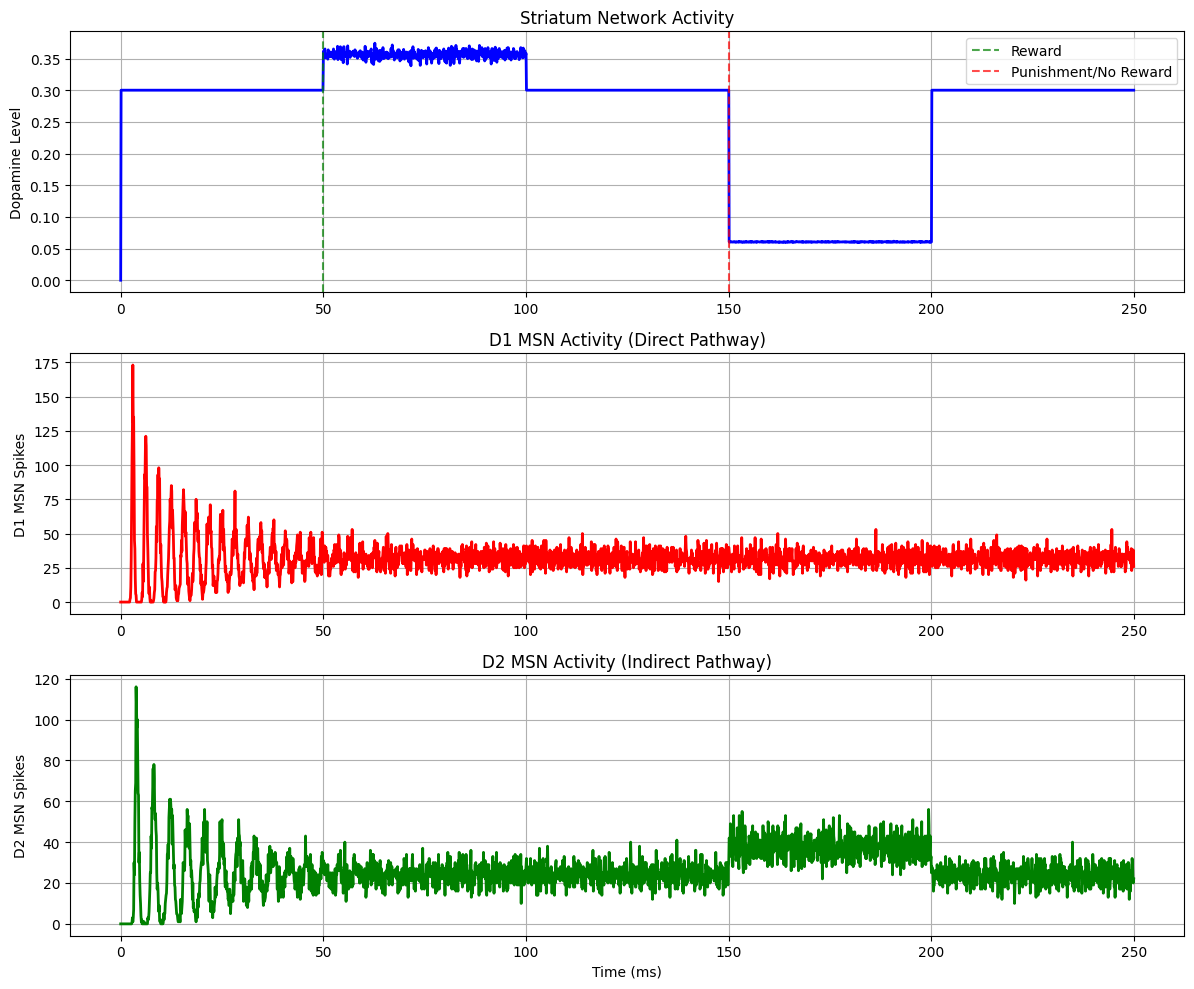


Simulation completed!
Network size: 3600 neurons
Average dopamine level: 0.263
Peak dopamine level: 0.374
Average D1 activity: 31.66 spikes/step
Average D2 activity: 26.54 spikes/step


In [21]:

# Example usage
if __name__ == "__main__":
    # Create network with specified neuron counts
    print("Creating large-scale striatum network...")
    
    # You can adjust these numbers based on computational resources
    # For demonstration, using smaller numbers than requested
    network = StriatumNetwork(
        n_d1_msn=1000,      # 1000 for full scale
        n_d2_msn=1000,      # 1000 for full scale  
        n_vta_da=1000,       # 1000 for full scale
        n_vta_gaba=300,     # 300 for full scale
        n_vp_gaba=300       # 300 for full scale
    )
    
    # For full scale (warning: will be computationally intensive):
    # network = StriatumNetwork(
    #     n_d1_msn=1000,
    #     n_d2_msn=1000, 
    #     n_vta_da=1000,
    #     n_vta_gaba=300,
    #     n_vp_gaba=300
    # )
    
    print("Starting striatum network simulation...")
    print("Simulating reward and punishment scenarios...")
    
    # Run simulation
    network.simulate(duration=250.0)  # 250ms simulation
    
    # Plot results
    network.plot_results()
    
    # Print some statistics
    print(f"\nSimulation completed!")
    print(f"Network size: {sum(network.neuron_counts.values())} neurons")
    print(f"Average dopamine level: {np.mean(network.dopamine_history):.3f}")
    print(f"Peak dopamine level: {np.max(network.dopamine_history):.3f}")
    print(f"Average D1 activity: {np.mean(network.d1_activity):.2f} spikes/step")
    print(f"Average D2 activity: {np.mean(network.d2_activity):.2f} spikes/step")